In [4]:
import polars as pl  
from pathlib import Path

file_path = "Input_Data/waterloodata.csv"
waterloodata = pl.read_csv(file_path)

# Make sure output folder exists
outdir = Path("WaterlooProperties")
outdir.mkdir(parents=True, exist_ok=True)

def save_prop(df: pl.DataFrame, name: str, filename: str):
    df.filter(pl.col("Property Name") == name).write_csv(outdir / filename)

save_prop(waterloodata, "Bridgeport House", "Bridgeport_House_filtered_output.csv")
save_prop(waterloodata, "Fergus House", "Fergus_House_filtered_output.csv")
save_prop(waterloodata, "Hespeler House", "Hespeler_House_filtered_output.csv")
save_prop(waterloodata, "Preston House", "Preston_House_filtered_output.csv")
save_prop(waterloodata, "308 King", "308_King_filtered_output.csv")
save_prop(waterloodata, "MyRez on Lester", "MyRez_on_Lester_filtered_output.csv")
save_prop(waterloodata, "King Street Towers", "King_Street_Towers_filtered_output.csv")


In [5]:
import pandas as pd
import numpy as np

average_prices_df = pd.read_excel(r"Input_Data/Average Prices.xlsx", sheet_name=None)   
waterlooProperties = ["308_King", "Bridgeport_House", "Fergus_House", "Preston_House", "King_Street_Towers", "Hespeler_House", "MyRez_on_Lester"]

# outdir = Path("WaterlooPropertiesCleanedRent")
# outdir.mkdir(parents=True, exist_ok=True)

def build_price_lookup(avg_prices_obj, property_name="1Eleven", prop_col="Property", type_col="Bedroom Type", price_col="Average Price"):
        if isinstance(avg_prices_obj, dict):
            if property_name in avg_prices_obj:
                dfp = avg_prices_obj[property_name].copy()
            else:
                dfp = pd.concat(avg_prices_obj.values(), ignore_index=True)
        else:
            dfp = avg_prices_obj.copy()

        dfp.columns = [str(c).strip() for c in dfp.columns]
        if prop_col in dfp.columns:
            dfp = dfp[dfp[prop_col].astype(str).str.strip().str.casefold() == property_name.casefold()]

        dfp[type_col] = dfp[type_col].astype(str).str.strip().str.upper()
        dfp[price_col] = pd.to_numeric(dfp[price_col], errors="coerce")

        price_map = dfp.groupby(type_col)[price_col].median().dropna().to_dict()
        return price_map

def clean_scheduled_rent(df, price_lookup, unit_col="Unit Type", rent_col="Scheduled Rent", bed_col="Bedroom Count", tolerance_pct=0.10, tolerance_abs=50):
        out = df.copy()

        out[rent_col] = pd.to_numeric(out[rent_col], errors="coerce")
        out[bed_col] = pd.to_numeric(out[bed_col], errors="coerce")
        out["_UNIT_KEY"] = out[unit_col].astype(str).str.strip().str.upper()

        out["expected_rent"] = out["_UNIT_KEY"].map(price_lookup)

        has_rent = out[rent_col].notna() & (out[rent_col] > 0)
        has_expected = out["expected_rent"].notna()
        mask = has_rent & has_expected

        out["scheduled_rent_cleaned"] = out[rent_col]
        out["clean_reason"] = np.where(mask, "as_is_check", "not_checked")

        # Check if the scheduled rent is reasonably close to what our tiers are
        def close_enough(given, expected):
            return (given - expected).abs() <= np.maximum(tolerance_abs, tolerance_pct * expected)

        given = out.loc[mask, rent_col]
        expected = out.loc[mask, "expected_rent"]
        within_now = close_enough(given, expected)

        out.loc[mask & within_now, "clean_reason"] = "kept_as_is"

        to_try_perbed = mask & ~within_now.reindex(out.index, fill_value=False)

        # Divide by number of bedrooms and see if that was the issue
        perbed = out.loc[to_try_perbed, rent_col] / out.loc[to_try_perbed, bed_col].replace(0, np.nan)
        perbed_within = close_enough(perbed, out.loc[to_try_perbed, "expected_rent"])

        out.loc[to_try_perbed & perbed_within.reindex(out.index, fill_value=False), "scheduled_rent_cleaned"] = perbed
        out.loc[to_try_perbed & perbed_within.reindex(out.index, fill_value=False), "clean_reason"] = "divided_by_bedrooms"

        still_off = to_try_perbed & ~perbed_within.reindex(out.index, fill_value=False)
        out.loc[still_off, "scheduled_rent_cleaned"] = out.loc[still_off, "expected_rent"]
        
        # If dividing still didn't work, replace with average (tier value for bedroom type)
        out.loc[still_off, "clean_reason"] = "replaced_with_average"

        # should never happen, but just in case
        out.loc[has_rent & ~has_expected, "clean_reason"] = "no_match_in_average_prices"
        out.drop(columns=["_UNIT_KEY"], inplace=True)
        
        return out

for property in waterlooProperties:
    csv_path = f"WaterlooProperties/{property}_filtered_output.csv"         
    temp_df = pd.read_csv(csv_path)

    property_formatted = property.replace("_", " ")    
    price_lookup = build_price_lookup(average_prices_df, property_name=property_formatted)
    
    temp_df_cleaned = clean_scheduled_rent(temp_df, price_lookup, unit_col="Unit Type", rent_col="Scheduled Rent", bed_col="Bedroom Count", tolerance_pct=0.50, tolerance_abs=500)
    cleaned_csv_path = f"WaterlooPropertiesCleanedRent/{property}_cleaned.csv"
    
    temp_df_cleaned.to_csv(cleaned_csv_path, index=False)

C:\Users\JackE\AppData\Local\Temp\ipykernel_33088\1681279398.py:78: DtypeWarning: Columns (23,24,25,26,27,28,29,30,31,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv(csv_path)
C:\Users\JackE\AppData\Local\Temp\ipykernel_33088\1681279398.py:78: DtypeWarning: Columns (23,24,25,26,27,28,29,30,31,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv(csv_path)
C:\Users\JackE\AppData\Local\Temp\ipykernel_33088\1681279398.py:78: DtypeWarning: Columns (23,24,25,26,27,28,29,30,31,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv(csv_path)
C:\Users\JackE\AppData\Local\Temp\ipykernel_33088\1681279398.py:78: DtypeWarning: Columns (23,25,27,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv(csv_path)
C:\Users\JackE\AppData\Local\Temp\ipykernel_33088\1681279398.py:78: DtypeWarning: Colu

In [ ]:
import pyodbc
import pandas as pd
from dotenv import load_dotenv
import os

load_dotenv()

AZURE_CLIENT_SECRET = os.getenv("AZURE_CLIENT_SECRET")
AZURE_CLIENT_ID = os.getenv("AZURE_CLIENT_ID")
AZURE_TENANT_ID = os.getenv("AZURE_TENANT_ID")
SERVER = os.getenv("SQL_SERVER")
DATABASE = os.getenv("SQL_DATABASE")

# username: Your Forum AM email
username = 'JackE@forumam.com'

# table: choose the table you want to load to
table = 'entrataunitdetails'

# auth: Keep as is (for now?)
auth = 'ActiveDirectoryInteractive'

# ENCRYPT defaults to yes starting in ODBC Driver 18. It's good to always specify ENCRYPT=yes on the client side to avoid MITM attacks.
cnxn = pyodbc.connect('DRIVER={ODBC Driver 18 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';Authentication='+auth+';UID='+username+';ENCRYPT=yes')
cursor = cnxn.cursor()

cursor.execute("SELECT TOP(10) * FROM "+table)
row = cursor.fetchone()

while row:
   print(row[0]+'|'+row[1])
   row = cursor.fetchone()


cnxn.commit()

In [ ]:
import pandas as pd
import os
files = os.listdir("WaterlooPropertiesCleanedRent")

results = []
for file in files:
    temp_df = pd.read_csv("WaterlooPropertiesCleanedRent/"+file, low_memory=False)
    property_name = file.replace("_cleaned", "").split('.')[0]
    # Take all data as of Jan 1 2025
    temp_df = temp_df[temp_df["Event Date"] >= "2025-01-01"]
    avg_revenue_property = temp_df["scheduled_rent_cleaned"].mean()
    results.append({
        "PropertyName": property_name,
        "AvgRevenue": avg_revenue_property
    })

property_summary = pd.DataFrame(results)
property_summary = property_summary[property_summary["AvgRevenue"].notna()]
property_summary

C:\Users\JackE\AppData\Local\Temp\ipykernel_4492\1156292415.py:6: DtypeWarning: Columns (23,24,25,26,27,28,29,30,31,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


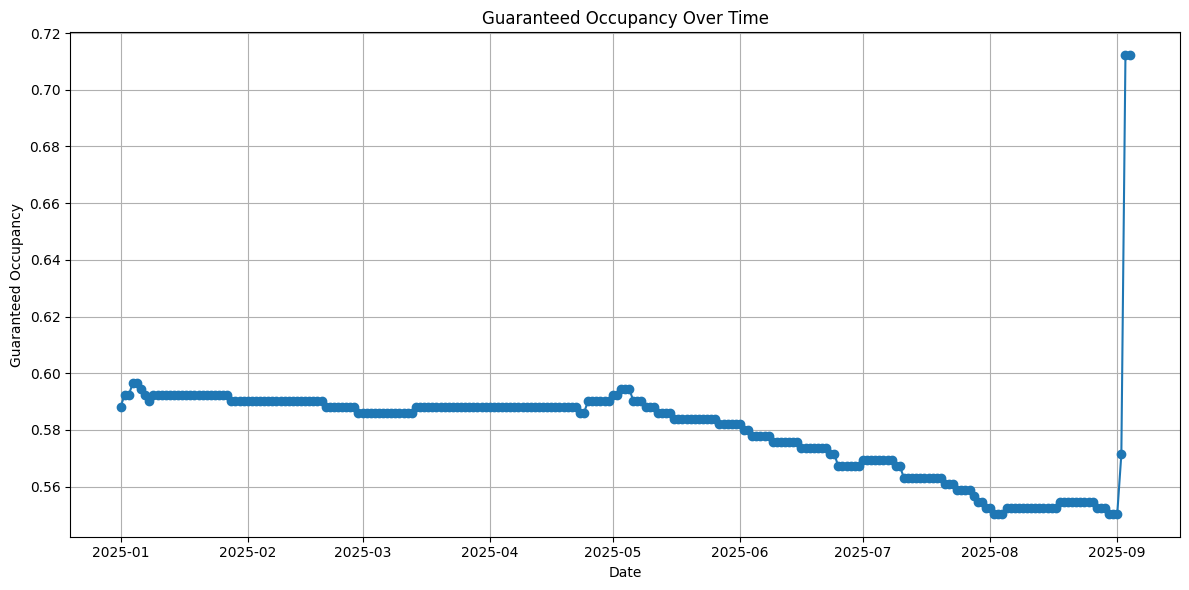

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
file_path = 'WaterlooPropertiesCleanedRent/Fergus_House_cleaned.csv'
df = pd.read_csv(file_path)

# Ensure Event Date is datetime
df['Event Date'] = pd.to_datetime(df['Event Date'])
df = df[df['Event Date'] >= pd.Timestamp(2025,1,1)]
# Group by day: count total units and "Occupied No Notice"
daily = df.groupby('Event Date').agg(
    total_units=('Unit Status', 'count'),
    occupied_no_notice=('Unit Status', lambda x: (x == 'Occupied No Notice').sum())
).reset_index()

# Compute ratio
daily['vacancy_ratio'] = daily['occupied_no_notice'] / daily['total_units']

# Plot
plt.figure(figsize=(12,6))
plt.plot(daily['Event Date'], daily['vacancy_ratio'], marker='o', linestyle='-')
plt.title("Guaranteed Occupancy Over Time")
plt.xlabel("Date")
plt.ylabel("Guaranteed Occupancy")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\JackE\AppData\Local\Temp\ipykernel_4492\1536720387.py:6: DtypeWarning: Columns (23,24,25,26,27,28,29,30,31,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


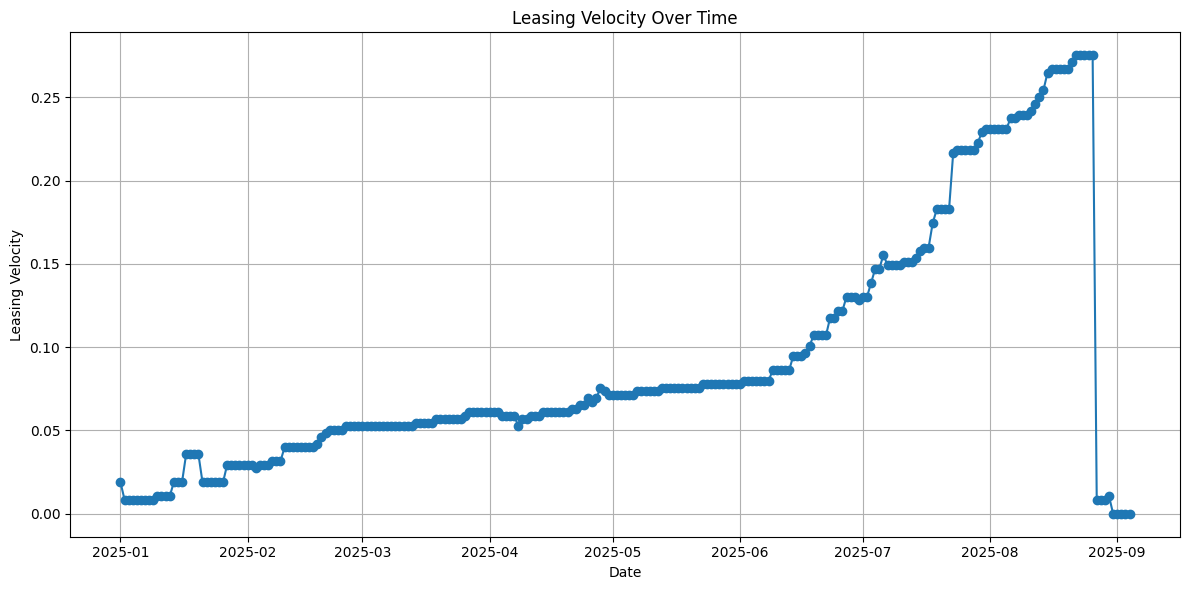

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
file_path = 'WaterlooPropertiesCleanedRent/Fergus_House_cleaned.csv'
df = pd.read_csv(file_path)

# Ensure Event Date is datetime
df['Event Date'] = pd.to_datetime(df['Event Date'])
df = df[df['Event Date'] >= pd.Timestamp(2025,1,1)]
# Group by day: count total units and "Occupied No Notice"
daily = df.groupby('Event Date').agg(
    total_units=('Unit Status', 'count'),
    vacant_rented=('Unit Status', 
                   lambda x: ((x == 'Notice Rented')).sum())
).reset_index()

# Compute ratio
daily['leasing_rate'] = daily['vacant_rented'] / daily['total_units']
# daily['leasing_rate_change'] = daily['leasing_rate'].diff()

# Plot
plt.figure(figsize=(12,6))
plt.plot(daily['Event Date'], daily['leasing_rate'], marker='o', linestyle='-')
plt.title("Leasing Velocity Over Time")
plt.xlabel("Date")
plt.ylabel("Leasing Velocity")
plt.grid(True)
plt.tight_layout()
plt.show()


### Very Rough "Algorithm"

In [40]:
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta

INPUT_PATH = "WaterlooPropertiesCleanedRent/Fergus_House_cleaned.csv"
OUTPUT_PATH = "fergus_house_daily_pricing_decisions.csv"

PREMIUM_MAX = 150.0   # $ over market median
PREMIUM_MIN = 50.0    # floor premium to preserve brand positioning
STEP_BIG   = 50.0     # $ change for materially behind pace
STEP_SMALL = 25.0     # $ change for slightly behind / ahead

BEHIND_THRESHOLD_HIGH = -0.10  # actual - target <= -10% -> big decrease
BEHIND_THRESHOLD_LOW  = -0.05  # actual - target <= -5%  -> small decrease
AHEAD_THRESHOLD       = 0.05   # actual - target >= +5%  -> small increase

# Decision cadence: adjust price only on Mondays
DECISION_WEEKDAY = 0  # Monday = 0, Sunday = 6

# Target curve parameters (default Jan 1 -> Sep 1 of each year)
SEASON_START_MONTH = 1
SEASON_START_DAY   = 1
MOVE_IN_MONTH      = 9
MOVE_IN_DAY        = 1

DEFAULT_MARKET_MEDIAN = 950.0

# --- CONFIG ---
START_TARGET_PCT = 0.60  # target at season start (e.g., Jan 1)
END_TARGET_PCT   = 0.85  # target at move-in (e.g., Sep 1)

# sets a daily target occupancy percent over a time horizon
def target_occupancy_pct(current_date: pd.Timestamp) -> float:
    """Ramps from START_TARGET_PCT at season_start to END_TARGET_PCT at move_in."""
    year = current_date.year
    season_start = pd.Timestamp(year=year, month=SEASON_START_MONTH, day=SEASON_START_DAY)
    move_in      = pd.Timestamp(year=year, month=MOVE_IN_MONTH,   day=MOVE_IN_DAY)

    # If we're past this year's move-in, switch to next season’s targets
    if current_date > move_in:
        year += 1
        season_start = pd.Timestamp(year=year, month=SEASON_START_MONTH, day=SEASON_START_DAY)
        move_in      = pd.Timestamp(year=year, month=MOVE_IN_MONTH,   day=MOVE_IN_DAY)

    # Before season starts: hold the start target
    if current_date < season_start:
        return float(START_TARGET_PCT)

    total_days = (move_in - season_start).days
    if total_days <= 0:
        return float(END_TARGET_PCT)

    elapsed = (current_date - season_start).days
    frac = min(max(elapsed / total_days, 0.0), 1.0)  # 0..1
    return float(START_TARGET_PCT + frac * (END_TARGET_PCT - START_TARGET_PCT))


df = pd.read_csv(INPUT_PATH, low_memory=False)
df["Event Date"] = pd.to_datetime(df["Event Date"])

# Filter to dates starting from 2025-01-01
df = df[df["Event Date"] >= pd.Timestamp("2025-01-01")].copy()
if df.empty:
    # If there's no 2025 data, don't crash—fall back to using all data but flag later
    df = pd.read_csv(INPUT_PATH, low_memory=False)
    df["Event Date"] = pd.to_datetime(df["Event Date"])

# Keep only columns we need and ensure we don't have any na's
cols_needed = ["Event Date", "Unit Space ID", "Unit Status"]
df = df[cols_needed].dropna(subset=["Event Date", "Unit Space ID", "Unit Status"]).copy()

# sort by day and drop duplicates
df.sort_values(["Event Date", "Unit Space ID"], inplace=True)
df = df.drop_duplicates(subset=["Event Date", "Unit Space ID"], keep="last")

# Unit Status Values
EFFECTIVE_OCCUPIED = {
    "Occupied No Notice",
    "Notice Rented",
    "Vacant Rented Ready",
    "Vacant Rented Not Ready",
}
EFFECTIVE_VACANT = {
    "Notice Unrented",
    "Vacant Unrented Ready",
    "Vacant Unrented Not Ready",
}

# Bucket occupancy by occupied and vacant
def status_to_bucket(s: str) -> str:
    if s in EFFECTIVE_OCCUPIED:
        return "effective_occupied"
    elif s in EFFECTIVE_VACANT:
        return "effective_vacant"
    else:
        return "unknown"

df["bucket"] = df["Unit Status"].map(status_to_bucket)

# calculate daily vacant and occupied statuses
daily = (
    df.groupby("Event Date")
      .agg(
          total_beds=("Unit Space ID", "nunique"),
          effective_occupied=("bucket", lambda x: (x == "effective_occupied").sum()),
          effective_vacant=("bucket", lambda x: (x == "effective_vacant").sum()),
          unknown_status=("bucket", lambda x: (x == "unknown").sum()),
      )
      .reset_index()
      .sort_values("Event Date")
)

# Recompute vacant numbers
daily["effective_vacant"] = daily["total_beds"] - daily["effective_occupied"]
daily["occupancy_pct"] = (daily["effective_occupied"] / daily["total_beds"]).astype(float)

# Target occupancy and gap (daily)
daily["target_occupancy_pct"] = daily["Event Date"].apply(target_occupancy_pct)
daily["occupancy_gap"] = (daily["occupancy_pct"] - daily["target_occupancy_pct"]).astype(float)

market_median = DEFAULT_MARKET_MEDIAN

records = []
# start the backtest at the maximum premium
current_premium = PREMIUM_MAX 
last_decision_date = None

for idx, row in daily.iterrows():
    d = pd.Timestamp(row["Event Date"]).normalize()
    total_beds = int(row["total_beds"])
    occ = float(row["occupancy_pct"])
    target = float(row["target_occupancy_pct"])
    gap = float(row["occupancy_gap"])
    
    decision_day = (d.weekday() == DECISION_WEEKDAY)
    action = "hold (non-decision day)"
    premium_before = current_premium
    premium_after = current_premium
    note = ""

    # if it's a monday we decide what to do
    if decision_day:
        # Decide premium adjustment based on gap
        if gap <= BEHIND_THRESHOLD_HIGH:
            premium_after = max(PREMIUM_MIN, current_premium - STEP_BIG)
            action = "decrease"
            note = f"Behind pace by {gap:.1%} (<= {BEHIND_THRESHOLD_HIGH:.0%}); -${STEP_BIG:.0f}"
        elif gap <= BEHIND_THRESHOLD_LOW:
            premium_after = max(PREMIUM_MIN, current_premium - STEP_SMALL)
            action = "decrease"
            note = f"Behind pace by {gap:.1%} (<= {BEHIND_THRESHOLD_LOW:.0%}); -${STEP_SMALL:.0f}"
        elif gap >= AHEAD_THRESHOLD:
            premium_after = min(PREMIUM_MAX, current_premium + STEP_SMALL)
            action = "increase"
            note = f"Ahead of pace by {gap:.1%} (>= {AHEAD_THRESHOLD:.0%}); +${STEP_SMALL:.0f}"
        else:
            action = "hold"
            note = "On pace; no change"
        current_premium = premium_after
        last_decision_date = d

    ask_per_bed = market_median + current_premium

    records.append({
        "date": d.date().isoformat(),
        "weekday": d.day_name(),
        "decision_day": decision_day,
        "action": action,
        "note": note,
        "premium_before": premium_before,
        "premium_after": premium_after,
        "recommended_ask_per_bed": round(ask_per_bed, 2),
        "market_median_per_bed": round(market_median, 2),
        "occupancy_pct": round(occ, 4),
        "target_occupancy_pct": round(target, 4),
        "occupancy_gap": round(gap, 4),
        "total_beds": total_beds,
        "effective_occupied": int(row["effective_occupied"]),
        "effective_vacant": int(row["effective_vacant"]),
        "unknown_status": int(row["unknown_status"]),
    })

out = pd.DataFrame(records)
out.to_csv(OUTPUT_PATH, index=False)

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

df = pd.read_csv("Input_Data/comparable_properties.csv")
df = df[df["standardized price"] != 0]

# convert studio
df["beds"] = df["beds"].replace(0, 1)
# Prepare data (drop sqft as requested)
features = df.drop(columns=["url","address","price","standardized price","sqft", "smoking_allowed", "private_bathroom", "ensuite_washroom", "student_friendly", "internet"])
target = df["standardized price"]

# Fit linear regression
model = LinearRegression()
model.fit(features, target)

# Get feature importance (absolute value of coefficients)
importance = pd.DataFrame({
    "feature": features.columns,
    "coefficient": model.coef_,
    "abs_importance": np.abs(model.coef_)
}).sort_values("abs_importance", ascending=False)

# Average standardized rent by number of bedrooms
avg_rent_by_bedrooms = df.groupby("beds")["standardized price"].mean().reset_index()
avg_rent_by_bedrooms

               feature  coefficient  abs_importance
16    ensuite_bathroom   245.452218      245.452218
13             heating  -201.054284      201.054284
2   utilities_included   135.734054      135.734054
3              parking   124.982231      124.982231
19        gas_included   119.513581      119.513581


,beds,standardized price
0,1.0,1729.000000
1,1.5,1392.571429
2,2.0,1020.333333
3,3.0,951.933333
4,4.0,951.600000
5,5.0,852.642857


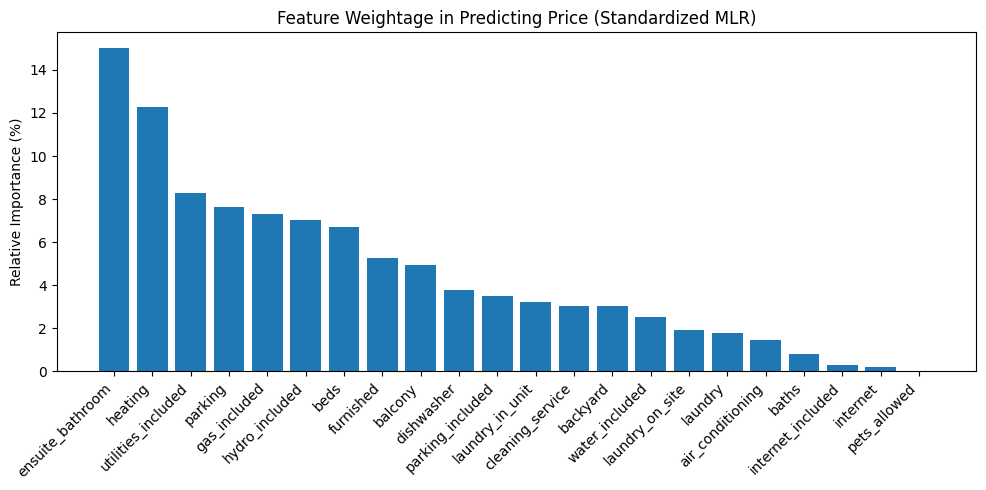

               feature          coef    weight_pct
16    ensuite_bathroom  2.454522e+02  1.499520e+01
13             heating -2.010543e+02  1.228284e+01
2   utilities_included  1.357341e+02  8.292285e+00
3              parking  1.249822e+02  7.635433e+00
19        gas_included  1.195136e+02  7.301341e+00
18      hydro_included -1.151426e+02  7.034310e+00
0                 beds -1.097626e+02  6.705636e+00
7            furnished -8.595903e+01  5.251422e+00
17             balcony -8.082572e+01  4.937817e+00
14          dishwasher  6.167946e+01  3.768130e+00
9     parking_included -5.716802e+01  3.492517e+00
10     laundry_in_unit -5.279569e+01  3.225402e+00
5     cleaning_service  4.981926e+01  3.043566e+00
6             backyard  4.981926e+01  3.043566e+00
20      water_included  4.163397e+01  2.543509e+00
11     laundry_on_site -3.109051e+01  1.899386e+00
4              laundry -2.906653e+01  1.775737e+00
12    air_conditioning  2.382745e+01  1.455670e+00
1                baths -1.30450

In [ ]:
coef_df = pd.DataFrame(list(zip(features.columns, model.coef_)), columns=["feature", "coef"])
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df["weight_pct"] = 100 * coef_df["abs_coef"] / coef_df["abs_coef"].sum()
coef_df = coef_df.sort_values("weight_pct", ascending=False)

# Bar plot of percentage weightage
plt.figure(figsize=(10,5))
plt.bar(coef_df["feature"], coef_df["weight_pct"])
plt.xticks(rotation=45, ha='right')
plt.ylabel("Relative Importance (%)")
plt.title("Feature Weightage in Predicting Price (Standardized MLR)")
plt.tight_layout()
plt.show()

In [39]:
from scipy import stats
import statsmodels.api as sm

df = pd.read_csv("Input_Data/comparable_properties.csv")
df = df[df["standardized price"] != 0]
# Amenity columns
amenity_cols = [
    "utilities_included","parking","laundry","furnished","internet","ensuite_bathroom","gas_included"
]

results = []
for col in amenity_cols:
    # Coerce to 0/1
    x = df[col].fillna(0).astype(int)
    y = df["standardized price"]

    # Only proceed if we have both groups and sufficient observations
    if x.nunique() == 2 and y.notna().sum() > 20:
        group0 = y[x == 0].dropna()
        group1 = y[x == 1].dropna()
        if len(group0) > 5 and len(group1) > 5:
            t_stat, p_val = stats.ttest_ind(group0, group1, equal_var=False)
            diff = group1.mean() - group0.mean()
            results.append({"amenity": col, "Mean Price (No)": group0.mean(), "Mean Price (Yes)": group1.mean(), "mean_diff": diff, "p_value": p_val})

amenity_effects = pd.DataFrame(results).sort_values("mean_diff", ascending=False)
amenity_effects.reset_index(drop=True, inplace=True)
amenity_effects.head(20)


,amenity,Mean Price (No),Mean Price (Yes),mean_diff,p_value
0,ensuite_bathroom,892.785388,1427.552381,534.766993,4.876454e-09
1,utilities_included,889.243056,1207.566667,318.323611,1.009979e-06
2,internet,900.984848,1179.598958,278.614110,1.276858e-05
3,gas_included,1020.939024,1208.487179,187.548155,1.133615e-01
4,furnished,1024.388889,1118.215278,93.826389,2.137829e-01
5,parking,1032.424242,1080.902222,48.477980,5.233742e-01
6,laundry,1044.280488,1079.435323,35.154836,5.937437e-01
